# **Import Libraries**

In [1]:
import os
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='librosa')

import numpy as np
import seaborn as sns
import librosa
import shutil
from io import BytesIO
from PIL import Image, ImageOps, ImageFile
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.optimizers import Adam

# Handle truncated image warnings in PIL
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Suppress TensorFlow logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 


2025-03-06 19:31:02.357380: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-06 19:31:02.357528: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-06 19:31:02.506778: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Data Preparation**

In [11]:
data_path = '/kaggle/input/arabic-alphabets-sign-language-dataset-arasl/ArASL_Database_54K_Final/ArASL_Database_54K_Final'

data = []  
labels = []  
categories = os.listdir(data_path)  # List of categories in this dataset

# Define max images per class for balanced dataset
max_images_per_class = 400  

# Load and preprocess images
for category in categories:
    category_path = os.path.join(data_path, category)
    images_loaded = 0 
    
    for img_name in os.listdir(category_path):
        if images_loaded >= max_images_per_class:
            break  # Stop loading more images if the limit is reached
        
        img_path = os.path.join(category_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale
        img = cv2.resize(img, (64, 64))  # Resize to 64x64 as per paper
        img = img / 255.0  # Normalize pixel values to [0,1]
        
        data.append(img.reshape(64, 64, 1))  # Reshape to fit model input
        labels.append(category)  # Store labels
        
        images_loaded += 1  # Increment counter

# Convert to numpy arrays
data = np.array(data)
labels = np.array(labels)

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
categorical_labels = to_categorical(encoded_labels, num_classes=32)  # Paper uses 14 classes

# Handle class imbalance using SMOTE
smote = SMOTE()
data_resampled, labels_resampled = smote.fit_resample(data.reshape(len(data), -1), encoded_labels)
data_resampled = data_resampled.reshape(-1, 64, 64, 1)  # Reshape back to image format
labels_resampled = to_categorical(labels_resampled, num_classes=32)


# **Splitting Dataset**

In [12]:
# Split dataset into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(data_resampled, labels_resampled, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Convert to numpy arrays
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

# Print dataset shapes
print(f'X_train shape is {X_train.shape}')
print(f'X_val shape is {X_val.shape}')
print(f'X_test shape is {X_test.shape}')
print(f'y_train shape is {y_train.shape}')
print(f'y_val shape is {y_val.shape}')
print(f'y_test shape is {y_test.shape}')

# Define QSLRS-CNN model from the paper
input_shape = (64, 64, 1)
num_classes = 32


X_train shape is (10240, 64, 64, 1)
X_val shape is (1280, 64, 64, 1)
X_test shape is (1280, 64, 64, 1)
y_train shape is (10240, 32)
y_val shape is (1280, 32)
y_test shape is (1280, 32)


# **Building a Model**

In [13]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.2),
    
    Conv2D(64, (3,3), activation='relu', padding='same'),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.2),
    
    Conv2D(128, (3,3), activation='relu', padding='same'),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),
    
    Conv2D(256, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Define optimizer and callbacks
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# **Training the Model**

In [14]:
history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
  7/320 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.0426 - loss: 7.9697   

I0000 00:00:1741290666.914072     109 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1741290666.934742     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


320/320 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - accuracy: 0.0759 - loss: 4.2047 - val_accuracy: 0.0320 - val_loss: 8.8469
Epoch 2/100


W0000 00:00:1741290671.743077     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.3555 - loss: 2.1005 - val_accuracy: 0.5695 - val_loss: 1.3730
Epoch 3/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.5473 - loss: 1.3798 - val_accuracy: 0.5516 - val_loss: 1.5117
Epoch 4/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.6547 - loss: 1.0366 - val_accuracy: 0.7773 - val_loss: 0.7202
Epoch 5/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7199 - loss: 0.8396 - val_accuracy: 0.6352 - val_loss: 1.1736
Epoch 6/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7610 - loss: 0.7120 - val_accuracy: 0.8883 - val_loss: 0.3707
Epoch 7/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.8047 - loss: 0.6085 - val_accuracy: 0.8578 - val_loss: 0.5151
Epoch 8/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.8312 - loss: 0.5236 - val_accuracy: 0.9023 - val_loss: 0.3292
Epoch 9/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.8434 - loss: 0.4722 - val_accuracy

# **Model Evaluation**

In [15]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9532 - loss: 0.1723
Test Accuracy: 95.31%


<h3 style="font-size: 16px;">7.1. Training and Validation Loss</h3>


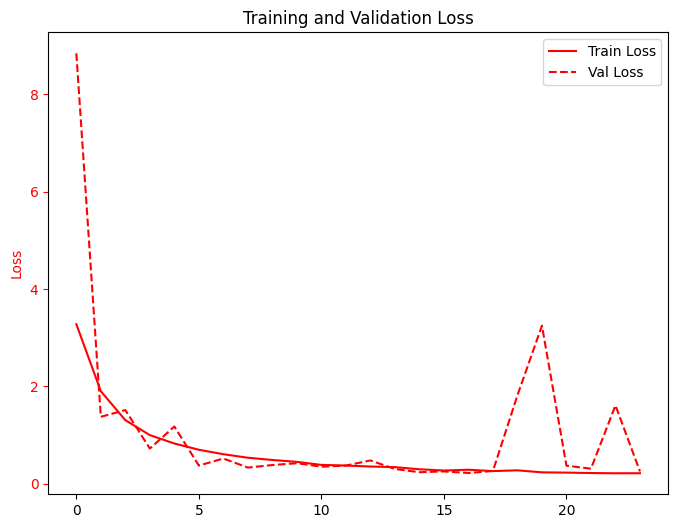

In [16]:
fig, ax2 = plt.subplots(figsize=(8, 6))
ax2.plot(history.history['loss'], 'r-', label='Train Loss')
ax2.plot(history.history['val_loss'], 'r--', label='Val Loss')
ax2.set_ylabel('Loss', color='r')
ax2.tick_params('y', colors='r')
ax2.legend(loc='upper right')

plt.title('Training and Validation Loss')
plt.show()

<h3 style="font-size: 16px;">7.2. Training and Validation Accuracy</h3>


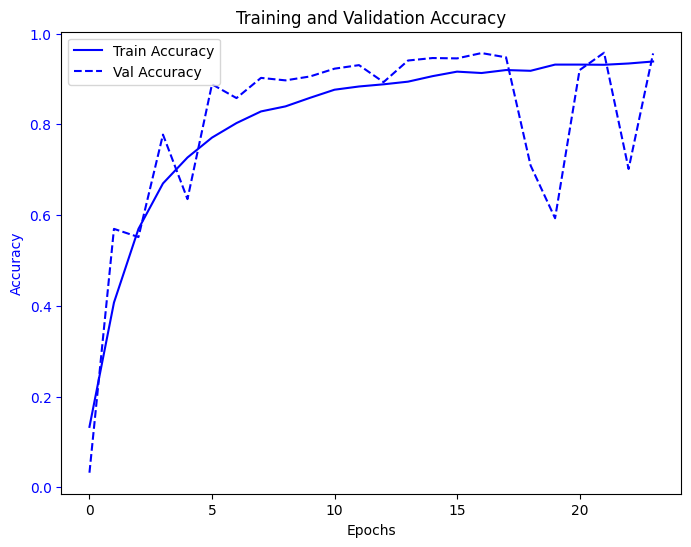

In [17]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot accuracy
ax1.plot(history.history['accuracy'], 'b-', label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], 'b--', label='Val Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy', color='b')
ax1.tick_params('y', colors='b')
plt.title('Training and Validation Accuracy')
ax1.legend(loc='upper left')

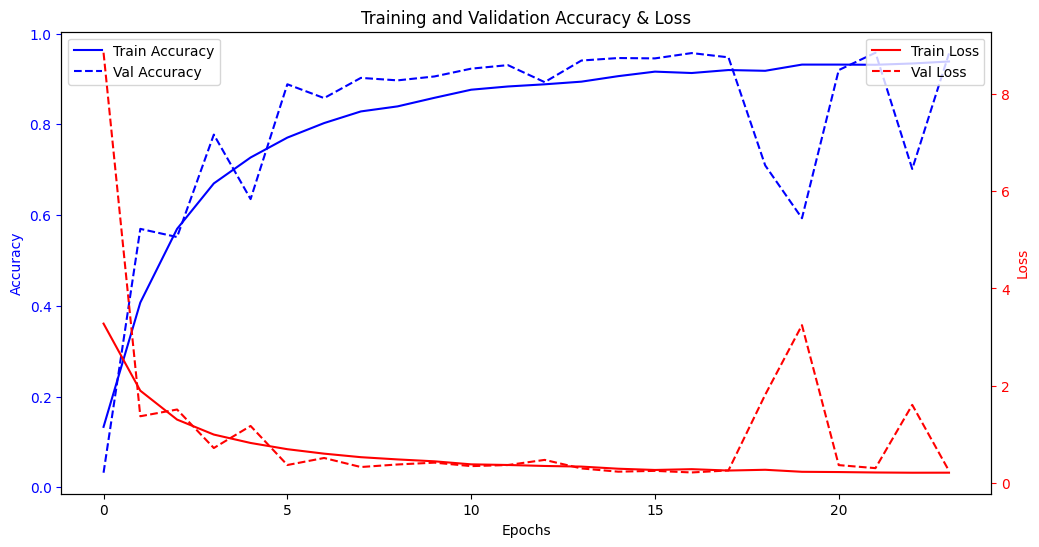

In [18]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot accuracy
ax1.plot(history.history['accuracy'], 'b-', label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], 'b--', label='Val Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy', color='b')
ax1.tick_params('y', colors='b')
ax1.legend(loc='upper left')

# Create a second y-axis for loss
ax2 = ax1.twinx()
ax2.plot(history.history['loss'], 'r-', label='Train Loss')
ax2.plot(history.history['val_loss'], 'r--', label='Val Loss')
ax2.set_ylabel('Loss', color='r')
ax2.tick_params('y', colors='r')
ax2.legend(loc='upper right')

plt.title('Training and Validation Accuracy & Loss')
plt.show()


<h3 style="font-size: 16px;">7.3. Confusion Matrix</h3>


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


W0000 00:00:1741291005.529547     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


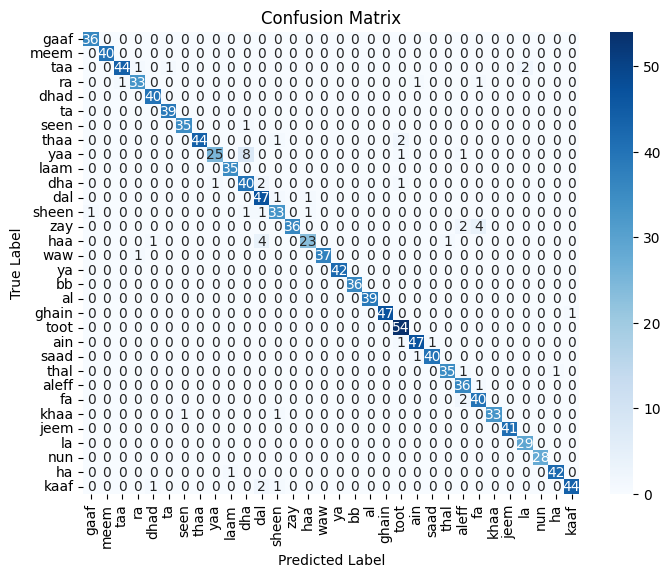

In [19]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



<h3 style="font-size: 16px;">7.4. Classification Report</h3>

In [20]:
print('\nClassification Report:')
print(classification_report(y_true_classes, y_pred_classes, target_names=categories))


Classification Report:
              precision    recall  f1-score   support

        gaaf       0.97      1.00      0.99        36
        meem       1.00      1.00      1.00        40
         taa       0.98      0.92      0.95        48
          ra       0.94      0.92      0.93        36
        dhad       0.95      1.00      0.98        40
          ta       0.97      1.00      0.99        39
        seen       0.97      0.97      0.97        36
        thaa       1.00      0.94      0.97        47
         yaa       0.96      0.71      0.82        35
        laam       0.97      1.00      0.99        35
         dha       0.80      0.91      0.85        44
         dal       0.84      0.96      0.90        49
       sheen       0.89      0.89      0.89        37
         zay       1.00      0.86      0.92        42
         haa       0.92      0.79      0.85        29
         waw       1.00      0.97      0.99        38
          ya       1.00      1.00      1.00        42
   

# **Test the Model**

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


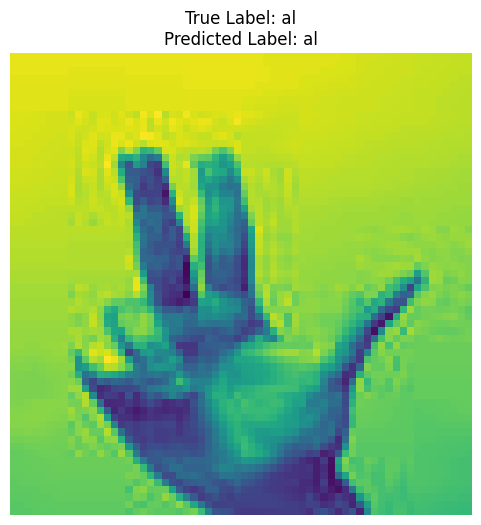

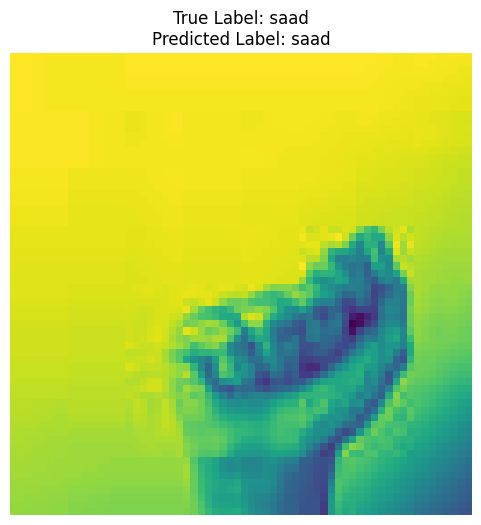

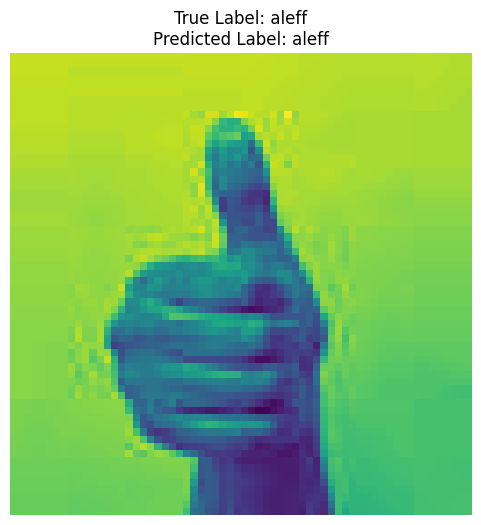

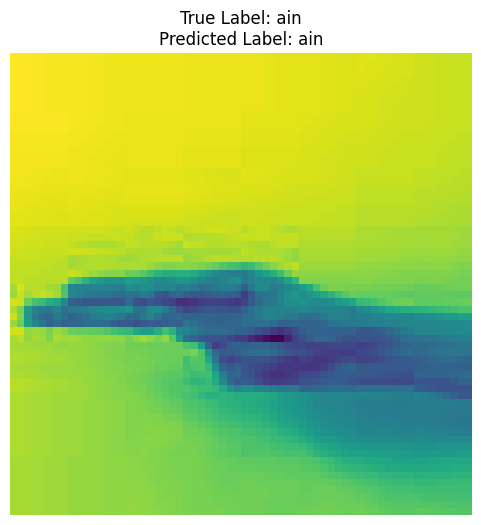

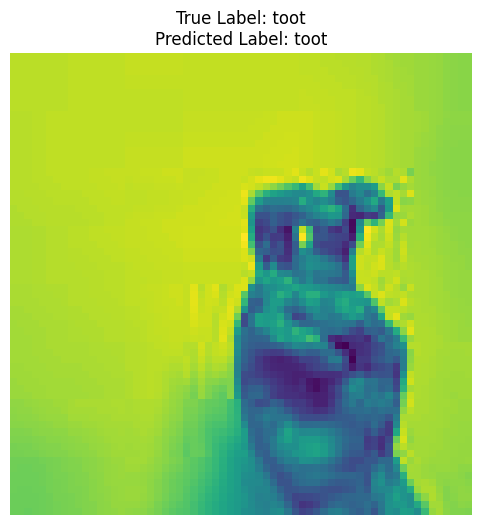

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Make predictions on test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Function to plot image with title
def plot_image(img_array, true_label, pred_label):
    plt.figure(figsize=(6, 6))
    plt.imshow(img_array)
    plt.title(f"True Label: {true_label}\nPredicted Label: {pred_label}")
    plt.axis('off')
    plt.show()

# Plot a few test images with actual and predicted class names
num_images_to_plot = 5 
for i in range(num_images_to_plot):
    # Get the image and its true label
    img = X_test[i]
    true_label = label_encoder.inverse_transform([y_true_classes[i]])[0]
    # Get the predicted label
    pred_label = label_encoder.inverse_transform([y_pred_classes[i]])[0]
    
    # Plot the image with title showing true and predicted labels
    plot_image(img, true_label, pred_label)



<h3 style="font-size: 16px;">8.1. Test the model in different dataset </h3>

In [29]:
from tensorflow.keras.models import Sequential, load_model
# Load and preprocess image for prediction
def preprocess_image(img_path):
    img = load_img(img_path, color_mode='grayscale', target_size=(64, 64))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=-1)  # Ensure shape (64,64,1)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array.astype(np.float32) / 255.0  # Normalize
    return img_array

# Load trained model for prediction
model = load_model("qslrs_cnn_model.h5")

# Predict an image
def predict_image(img_path):
    img_array = preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    confidence = np.max(predictions[0])
    return predicted_class, confidence

# Example usage
img_path = '/kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Yeh/Yeh_101.jpeg'
predicted_label, confidence = predict_image(img_path)
print(f"Predicted Label: {predicted_label}")
print(f"Confidence: {confidence:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Label: 0
Confidence: 0.7535


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


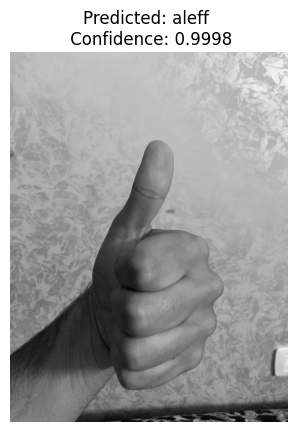

Predicted Label: aleff
Confidence: 0.9998


In [32]:
def predict_image(img_path):
    img_array = preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    confidence = np.max(predictions[0])
    
    # Display the image
    img = load_img(img_path, color_mode='grayscale')
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(f"Predicted: {class_labels[predicted_class]} \n Confidence: {confidence:.4f}")
    plt.show()
    
    return class_labels[predicted_class], confidence

# Example usage
img_path = '/kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Alef/Alef_106.jpeg'
predicted_label, confidence = predict_image(img_path)
print(f"Predicted Label: {predicted_label}")
print(f"Confidence: {confidence:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


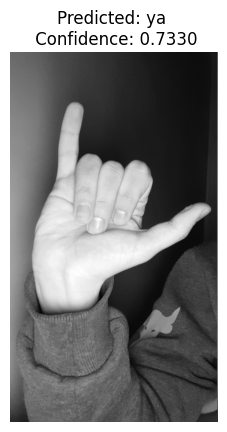

Predicted Label: ya
Confidence: 0.7330


In [34]:
def predict_image(img_path):
    img_array = preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    confidence = np.max(predictions[0])
    
    # Display the image
    img = load_img(img_path, color_mode='grayscale')
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(f"Predicted: {class_labels[predicted_class]} \n Confidence: {confidence:.4f}")
    plt.show()
    
    return class_labels[predicted_class], confidence

# Example usage
img_path = '/kaggle/input/rgb-arabic-alphabets-sign-language-dataset/RGB ArSL dataset/Yeh/Yeh_106.jpg'
predicted_label, confidence = predict_image(img_path)
print(f"Predicted Label: {predicted_label}")
print(f"Confidence: {confidence:.4f}")

# **Model Save Operation (H5 Format)**

In [27]:
# Save the trained model to an H5 file
model_save_path = '/kaggle/working/qslrs_cnn_model.h5'
model.save(model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to /kaggle/working/qslrs_cnn_model.h5
